In [8]:
from support import *

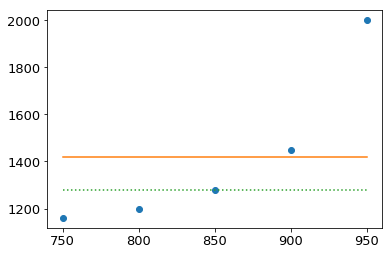

In [15]:
def data():
#     df = pd.DataFrame(data={"sqfeet":[700, 750, 800, 850, 900,950,1000]})
#     df["rent"] = pd.Series([1160, 1160, 1175, 1200, 1280,1310,2000])
    df = pd.DataFrame(data={"sqfeet":[750, 800, 850, 900,950]})
    df["rent"] = pd.Series([1160, 1200, 1280, 1450,2000])
    df = df.sort_values('sqfeet')
    return df

df = data()
df_l2 = df.copy()
df_l1 = df.copy()
plt.plot(df.sqfeet,df.rent,'o')

m = df.rent.mean()
mm = np.empty(len(df))
mm.fill(m)
plt.plot(df.sqfeet,mm)

md = df.rent.median()
md2 = np.empty(len(df))
md2.fill(md)
plt.plot(df.sqfeet,md2, linestyle=':')
plt.show()

## Show decision tree for L2 residual

In [10]:
eta = 1.0
M = 3
gbm_l2 = l2boost(df_l2, 'rent', eta, M)
print(gbm_l2.splits())
mse = np.array([mean_squared_error(df_l2.rent, df_l2['F'+str(s)]) for s in range(M+1)])
mse_sqrt = np.array(np.sqrt([mean_squared_error(df_l2.rent, df_l2['F'+str(s)]) for s in range(M+1)]))
mae = np.array([mean_absolute_error(df_l2.rent, df_l2['F'+str(s)]) for s in range(M+1)])
np.set_printoptions(precision=3)
print(mse)
print(mse_sqrt)
print(mae)

df_l2

[925.0, 825.0, 925.0]
[94384.     6175.     2170.833  1503.472]
[307.22   78.581  46.592  38.775]
[237.6    62.     40.333  30.   ]


,sqfeet,rent,F0,res1,delta1,F1,res2,delta2,F2,res3,delta3,F3
0,750,1160,1406.0,-246.0,-148.5,1257.5,-97.5,-77.500000,1180.000000,-20.000000,12.916667,1192.916667
1,800,1200,1406.0,-206.0,-148.5,1257.5,-57.5,-77.500000,1180.000000,20.000000,12.916667,1192.916667
2,850,1280,1406.0,-126.0,-148.5,1257.5,22.5,51.666667,1309.166667,-29.166667,12.916667,1322.083333
3,900,1390,1406.0,-16.0,-148.5,1257.5,132.5,51.666667,1309.166667,80.833333,12.916667,1322.083333
4,950,2000,1406.0,594.0,594.0,2000.0,0.0,51.666667,2051.666667,-51.666667,-51.666667,2000.000000


In [11]:
eta = 1.0
M = 3
gbm_l1 = l1boost(df_l1, 'rent', eta, M)
print(gbm_l1.splits())
mse = np.array([mean_squared_error(df_l1.rent, df_l1['F'+str(s)]) for s in range(M+1)])
mse_sqrt = np.array(np.sqrt([mean_squared_error(df_l1.rent, df_l1['F'+str(s)]) for s in range(M+1)]))
mae = np.array([mean_absolute_error(df_l1.rent, df_l1['F'+str(s)]) for s in range(M+1)])
print(mse)
print(mse_sqrt)
print(mae)
df_l1

[825.0, 775.0, 925.0]
[110260.  77000.  74920.   2700.]
[332.054 277.489 273.715  51.962]
[206. 152. 148.  28.]


,sqfeet,rent,F0,res1,sign1,delta1,F1,res2,sign2,delta2,F2,res3,sign3,delta3,F3
0,750,1160,1280.0,-120.0,-1.0,-100.0,1180.0,-20.0,-1.0,-20.0,1160.0,0.0,0.0,-5.0,1155.0
1,800,1200,1280.0,-80.0,-1.0,-100.0,1180.0,20.0,1.0,10.0,1190.0,10.0,1.0,-5.0,1185.0
2,850,1280,1280.0,0.0,0.0,110.0,1390.0,-110.0,-1.0,10.0,1400.0,-120.0,-1.0,-5.0,1395.0
3,900,1390,1280.0,110.0,1.0,110.0,1390.0,0.0,0.0,10.0,1400.0,-10.0,-1.0,-5.0,1395.0
4,950,2000,1280.0,720.0,1.0,110.0,1390.0,610.0,1.0,10.0,1400.0,600.0,1.0,600.0,2000.0


925.0


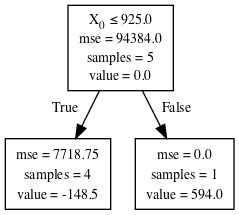

In [12]:
# t = tree.DecisionTreeRegressor(max_depth=1)
# t.fit(df.sqfeet.values.reshape(-1, 1), df.res1)
# t.predict(df.sqfeet.values.reshape(-1, 1))
# print(get_leaf_samples(t)[1], get_leaf_samples(t)[2])
# print(t.tree_.threshold[0])

t = L2Stump(df_l1.sqfeet, df_l2.res1)
print(t.split)

dot_data = StringIO()
tree.export_graphviz(t.tree_, dot_data, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


## Show decision tree for L1 residual

825.0


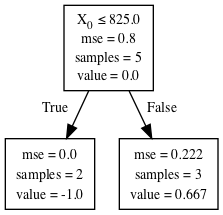

In [13]:
# t = tree.DecisionTreeRegressor(max_depth=1)
# t.fit(df.sqfeet.values.reshape(-1, 1), df.sign1)
# t.predict(df.sqfeet.values.reshape(-1, 1))
# print(get_leaf_samples(t)[1], get_leaf_samples(t)[2])
# print(t.tree_.threshold[0])

t = L1Stump(df_l1.sqfeet, df_l1.sign1, df_l1.res1)
print(t.split)

dot_data = StringIO()
tree.export_graphviz(t.tree_, dot_data, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())